<a href="https://colab.research.google.com/github/Macarena6MiMa/ProyectoML/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Cargar datos

In [ ]:
# 1. Instalar gdown (si no está instalado)
!pip install -q gdown

# 2. Descargar el ZIP desde Google Drive (usando gdown)
!gdown --id 1rBZQjj55ea7RxD0KN5v855FW3OFf-BAZ --output training2017.zip

# 3. Descomprimir el contenido en /content/training2017
!unzip -q training2017.zip -d /content/training2017

# 4. Definir ruta de trabajo
data_dir = r'/content/training2017/training2017'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rBZQjj55ea7RxD0KN5v855FW3OFf-BAZ
From (redirected): https://drive.google.com/uc?id=1rBZQjj55ea7RxD0KN5v855FW3OFf-BAZ&confirm=t&uuid=56bfa8dc-92ac-4df0-80a1-f5b8289bbe74
To: /content/training2017.zip
100% 99.2M/99.2M [00:01<00:00, 68.8MB/s]


1. Cargar y visualizar señales ECG

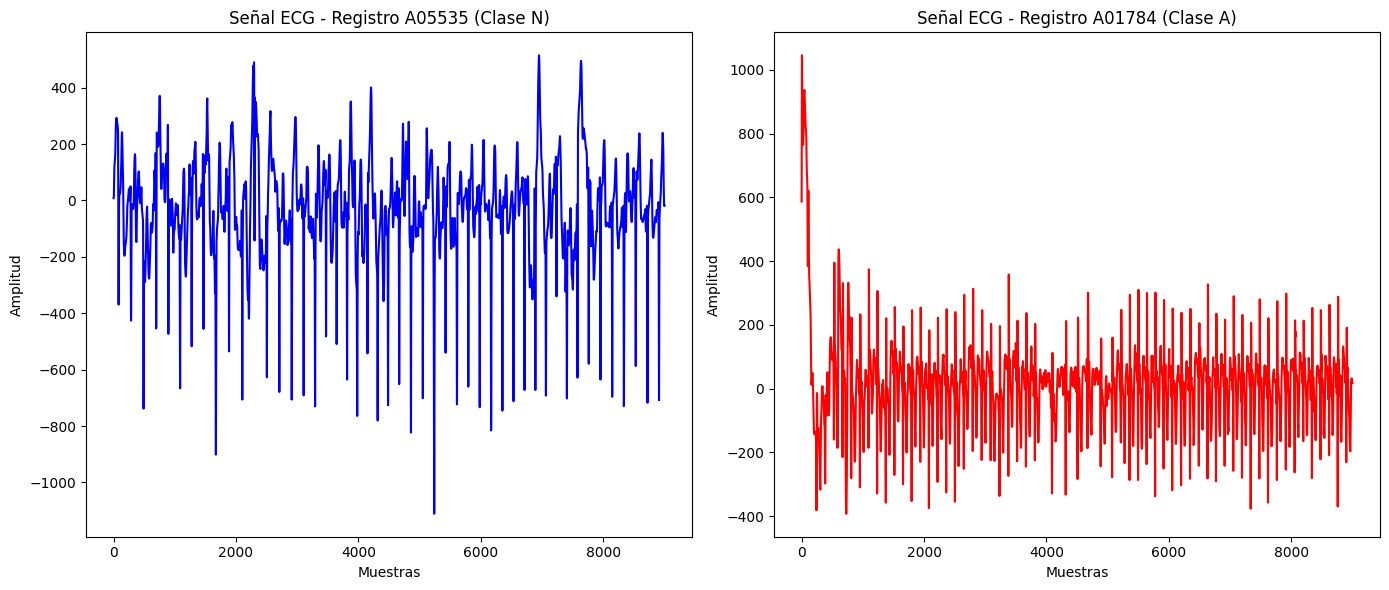

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]

# Cargar archivo REFERENCE.csv
reference_path = os.path.join(data_dir, 'REFERENCE.csv')
df_labels = pd.read_csv(reference_path, header=None, names=['registro', 'clase'])

feature_rows = []

for mat_file in mat_files:
    registro = mat_file.replace('.mat', '')
    mat_path = os.path.join(data_dir, mat_file)
    hea_path = os.path.join(data_dir, registro + '.hea')

    # Cargar señal
    mat_data = loadmat(mat_path)
    if 'val' not in mat_data:
        print(f"'val' key not found in {mat_file}")
        continue
    signal = mat_data['val'].flatten()

    # Cargar frecuencia de muestreo
    import os

    hea_path = os.path.join(data_dir, registro + '.hea')
    if not os.path.exists(hea_path):
      continue

    with open(hea_path, 'r') as f:
        fs = int(f.readline().split()[2])

    duracion_seq = len(signal) / fs
    media_mv = np.mean(signal)
    mstd_mv = np.std(signal)
    sk = skew(signal)
    kurt = kurtosis(signal)

    peaks, _ = find_peaks(signal, distance=fs*0.3)
    rr_intervals = np.diff(peaks) / fs if len(peaks) > 1 else [np.nan]
    rr_mean_s = np.mean(rr_intervals)
    rr_std_s = np.std(rr_intervals)
    # Buscar clase
    clase_row = df_labels[df_labels['registro'] == registro]
    clase = clase_row['clase'].values[0] if not clase_row.empty else 'Desconocida'

    feature_rows.append({
        'registro': registro,
        'fs': fs,
        'duracion_seq': duracion_seq,
        'media_mv': media_mv,
        'mstd_mv': mstd_mv,
        'skewness': sk,
        'kurtosis': kurt,
        'rr_mean_s': rr_mean_s,
        'rr_std_s': rr_std_s,
        'clase': clase
    })

# 5. Crear DataFrame final
df_features = pd.DataFrame(feature_rows)

# 6. Seleccionar un registro aleatorio de clase N y A
df_n = df_features[df_features['clase'] == 'N']
df_a = df_features[df_features['clase'] == 'A']

if len(df_n) == 0 or len(df_a) == 0:
    print("No hay suficientes registros de clase N y A para graficar.")
else:
    registro_n = df_n.sample(n=1, random_state=35)['registro'].values[0]
    registro_a = df_a.sample(n=1, random_state=35)['registro'].values[0]

    # 7. Cargar señales
    signal_n = loadmat(os.path.join(data_dir, registro_n + '.mat'))['val'].flatten()
    signal_a = loadmat(os.path.join(data_dir, registro_a + '.mat'))['val'].flatten()

    # 8. Visualización
    plt.figure(figsize=(14, 6))

    # Señal N
    plt.subplot(1, 2, 1)
    plt.plot(signal_n, color='blue')
    plt.title(f'Señal ECG - Registro {registro_n} (Clase N)')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')

    # Señal A
    plt.subplot(1, 2, 2)
    plt.plot(signal_a, color='red')
    plt.title(f'Señal ECG - Registro {registro_a} (Clase A)')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')

    plt.tight_layout()
    plt.show()

2.Inspección básica del dataset

In [ ]:
# Guardar resultados
df_features = pd.DataFrame(feature_rows)
df_features.to_csv(os.path.join(data_dir, 'caracteristicas_entrenamiento_con_clase.csv'), index=False)
# Mostrar primeras filas
print(df_features.head())
#a partir del csv generado, seleccionar 30 registros, 15 de cada clase (N y A) de forma aleatoria
output_path = os.path.join(data_dir, 'caracteristicas_entrenamiento_con_clase.csv')
# Cargar el CSV generado
df_features = pd.read_csv(output_path)
# Filtrar registros por clase
df_clase_1 = df_features[df_features['clase'].str.startswith('N')]
df_clase_2 = df_features[df_features['clase'].str.startswith('A')]
print("Registros que comienzan con 'N':", len(df_clase_1))
print("Registros que comienzan con 'A':", len(df_clase_2))

# Seleccionar 15 registros aleatorios de cada clase
selected_clase_1 = df_clase_1.sample(n=15, random_state=35)
selected_clase_2 = df_clase_2.sample(n=15, random_state=35)
# Concatenar los registros seleccionados
df_selected = pd.concat([selected_clase_1, selected_clase_2], ignore_index=True)
# Guardar el DataFrame seleccionado
output_selected_path = os.path.join(data_dir, 'caracteristicas_entrenamiento_seleccionadas.csv')
df_selected.to_csv(output_selected_path, index=False)
# Cargar el CSV de registros seleccionados
df_selected = pd.read_csv(output_selected_path)
#mostrar las primeras 30 filas del DataFrame seleccionado
print(df_selected.head())
print("\nResumen estadístico de las variables numéricas:")
print(df_selected.describe())

  registro   fs  duracion_seq   media_mv     mstd_mv  skewness   kurtosis  \
0   A03557  300         30.00  20.565556  304.333204 -0.287716  13.344529   
1   A05788  300         36.16  40.307706  299.418671  1.132224  18.900154   
2   A01828  300         30.00 -10.531889  166.823964  0.707935   5.479829   
3   A00277  300         30.00   5.812889  240.419745  0.756545  12.140946   
4   A07597  300         60.00  14.087389  126.314442  2.807606  11.168475   

   rr_mean_s  rr_std_s clase  
0   0.524386  0.148074     N  
1   0.521449  0.150332     O  
2   0.400090  0.046952     A  
3   0.572821  0.196899     N  
4   0.473148  0.153455     O  
Registros que comienzan con 'N': 5050
Registros que comienzan con 'A': 738
  registro   fs  duracion_seq   media_mv     mstd_mv  skewness   kurtosis  \
0   A05535  300          30.0 -25.811111  178.019951 -0.835734   3.174973   
1   A04579  300          30.0  12.306889  191.805207  1.600601   6.588945   
2   A08157  300          30.0  17.852889  185

3.Visualización de distribuciones

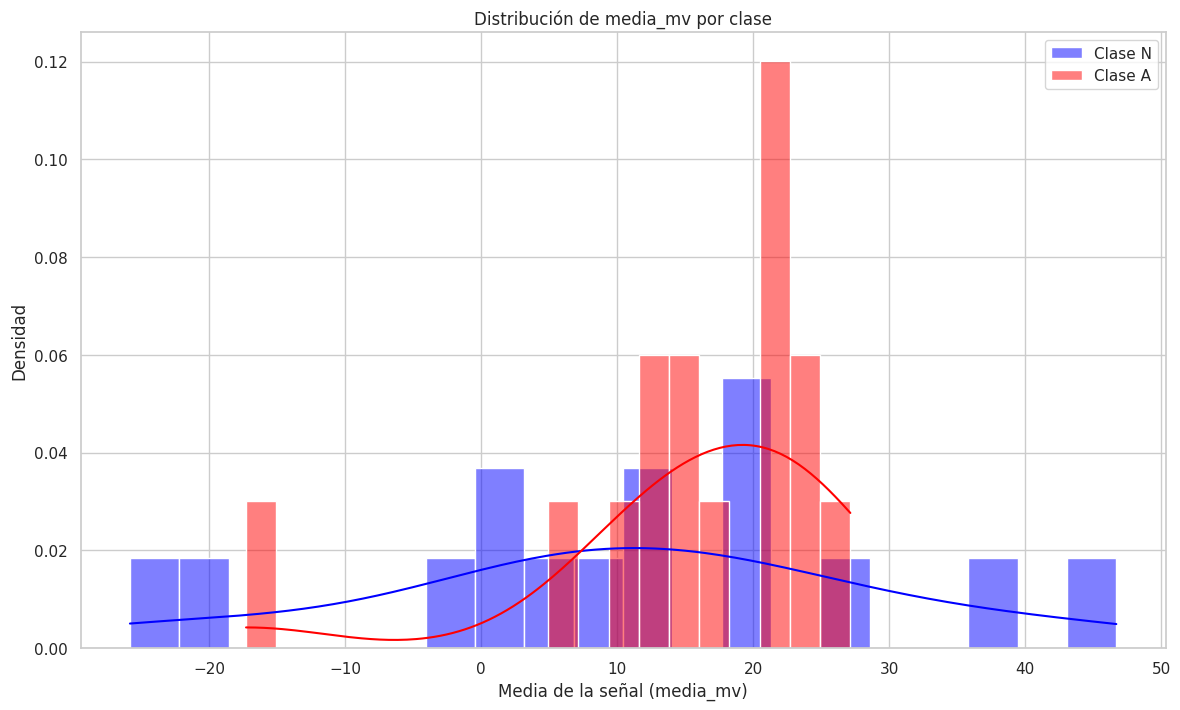

In [ ]:
#mostrar estadísticas descriptivas y con su curva normal con histogramas con transparencia y descripción y separados por colores para cada clase, rojo para A y azul N, pero en el mismo histograma
import matplotlib.pyplot as plt
import seaborn as sns
# Configuración de estilo
sns.set(style="whitegrid")
# Crear figura y ejes
plt.figure(figsize=(14, 8))
# Histograma de 'media_mv' para clase N
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['media_mv'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'media_mv' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['media_mv'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de media_mv por clase')
plt.xlabel('Media de la señal (media_mv)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()


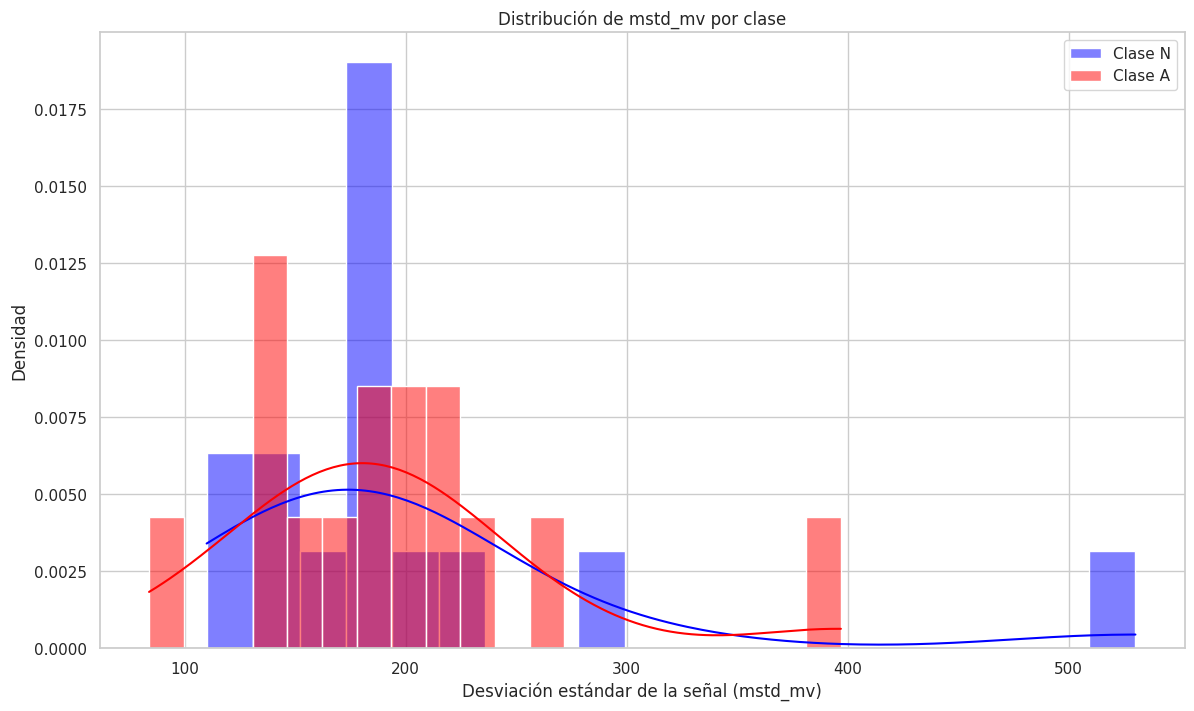

In [ ]:
# Histograma de 'mstd_mv' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['mstd_mv'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'mstd_mv' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['mstd_mv'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de mstd_mv por clase')
plt.xlabel('Desviación estándar de la señal (mstd_mv)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

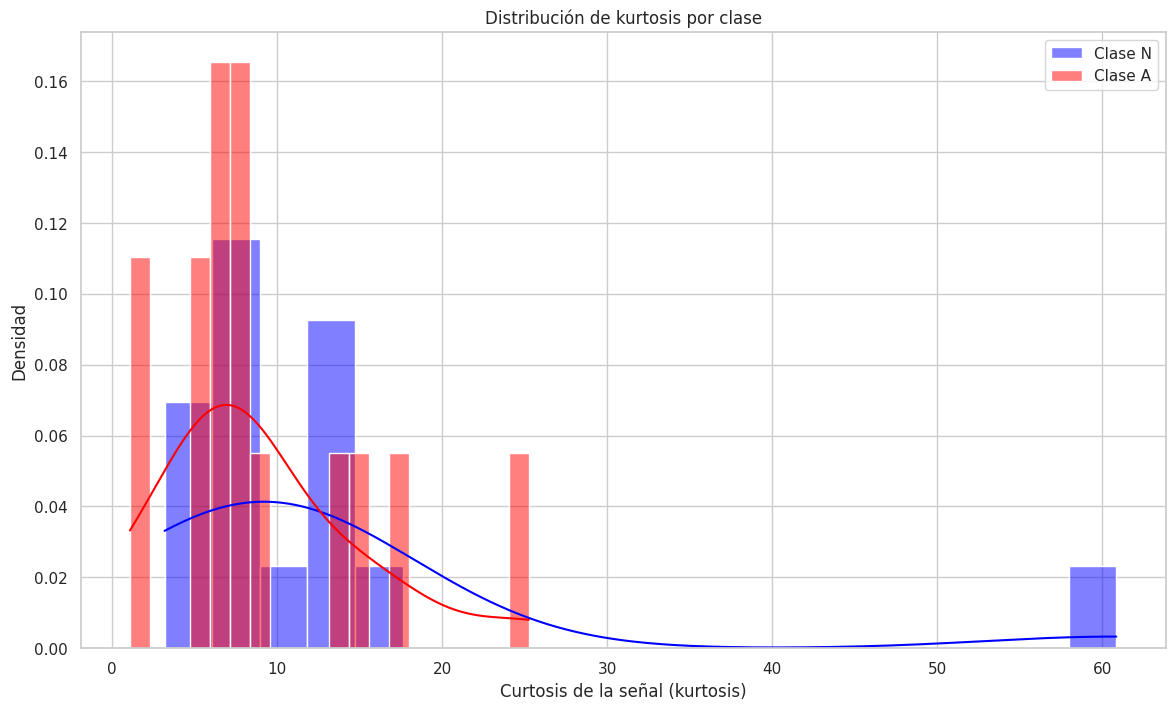

In [ ]:
# Histograma de 'kurtosis' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['kurtosis'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'kurtosis' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['kurtosis'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de kurtosis por clase')
plt.xlabel('Curtosis de la señal (kurtosis)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

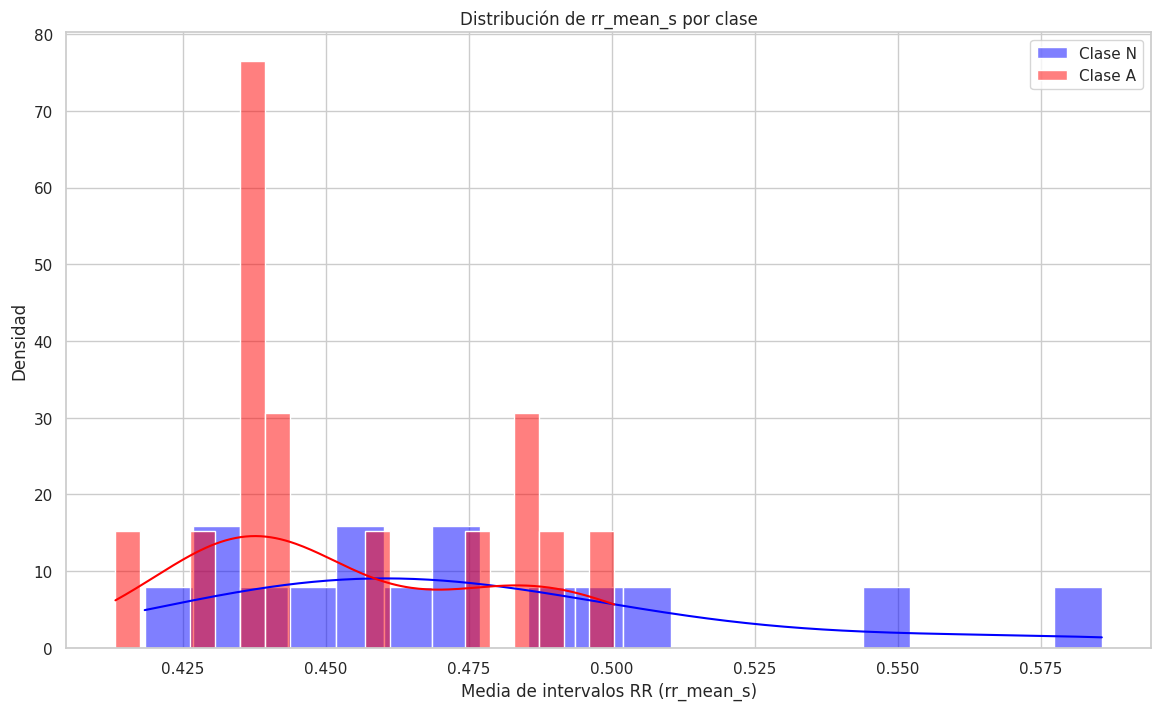

In [ ]:
# Histograma de 'rr_mean_s' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['rr_mean_s'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'rr_mean_s' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['rr_mean_s'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de rr_mean_s por clase')
plt.xlabel('Media de intervalos RR (rr_mean_s)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

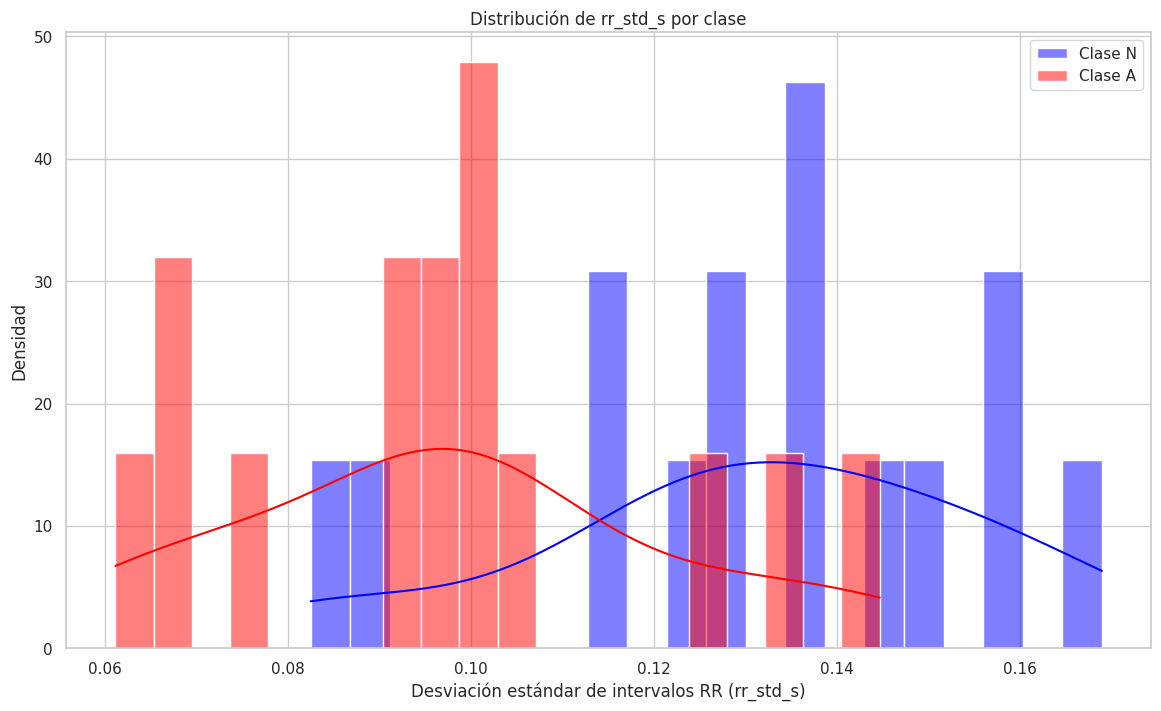

In [ ]:
# Histograma de 'rr_std_s' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['rr_std_s'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'rr_std_s' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['rr_std_s'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de rr_std_s por clase')
plt.xlabel('Desviación estándar de intervalos RR (rr_std_s)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

¿Qué variables parecen diferenciar más entre clases?

Las variables que parecen diferenciar más entre las clases N y A, basándonos en los histogramas y la distribución de los datos, son:
1. **Media de la señal (media_mv)**: La clase N muestra una distribución más concentrada y menos dispersa en comparación con la clase A, que tiene una mayor variabilidad.
2. **Desviación estándar de la señal (mstd_mv)**: Similar a la media, la clase N tiene una desviación estándar más baja, lo que indica menos variabilidad en la señal.
3. **Asimetría (skewness)**: La clase N tiende a tener una asimetría más cercana a cero, mientras que la clase A muestra una mayor asimetría, lo que indica que la distribución de los datos es más sesgada.
4. **Curtosis (kurtosis)**: La clase N tiene una curtosis más baja, lo que sugiere que la distribución es más plana en comparación con la clase A, que muestra picos más altos.
5. **Media de intervalos RR (rr_mean_s)**: La clase N tiene una media de intervalos RR más baja, lo que indica un ritmo cardíaco más regular en comparación con la clase A.
6. **Desviación estándar de intervalos RR (rr_std_s)**: La clase N muestra una desviación estándar más baja, lo que sugiere menos variabilidad en los intervalos RR en comparación con la clase A.


¿Qué aspectos del dataset llaman la atención?

Algunos aspectos que pueden llamar la atención del dataset son:
1. Desbalance de clases: Si hay una diferencia significativa en el número de registros entre las clases 'N' y 'A', esto puede afectar el rendimiento del modelo.
2. Distribución de características: Las distribuciones de las características como 'media_mv', 'mstd_mv', 'skewness', 'kurtosis', 'rr_mean_s' y 'rr_std_s' pueden mostrar diferencias significativas entre las clases, lo que puede ser útil para la clasificación.
4. Duración de las secuencias: La duración de las secuencias puede variar entre registros, lo que podría influir en el análisis temporal.
5. Comparación de estadísticas descriptivas: Las estadísticas descriptivas como la media, desviación estándar, asimetría y curtosis pueden proporcionar información sobre la naturaleza de las señales en cada clase.
6. Comportamiento de los intervalos RR: La media y desviación estándar de los intervalos RR pueden proporcionar información sobre la variabilidad de la frecuencia cardíaca en cada clase.
7. Visualización de distribuciones: Los histogramas y gráficos de densidad pueden ayudar a visualizar las diferencias en la distribución de las características entre las clases.
8. Comparación de clases: La comparación entre las clases 'N' y 'A' en términos de características puede revelar diferencias significativas que pueden ser útiles para la clasificación.
9. Análisis de la variabilidad de la frecuencia cardíaca: La variabilidad de la frecuencia cardíaca puede ser un indicador importante de la salud cardiovascular y puede variar entre las clases.

Entrenar Modelo

<ipython-input-19-1792977681>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_selected[df_features['clase'].isin(['N', 'A'])]


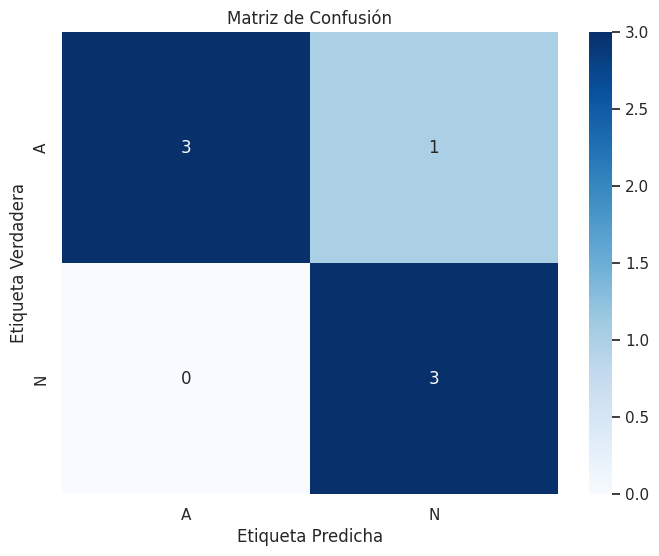


Reporte de Clasificación:
              precision    recall  f1-score   support

           A       1.00      0.75      0.86         4
           N       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7



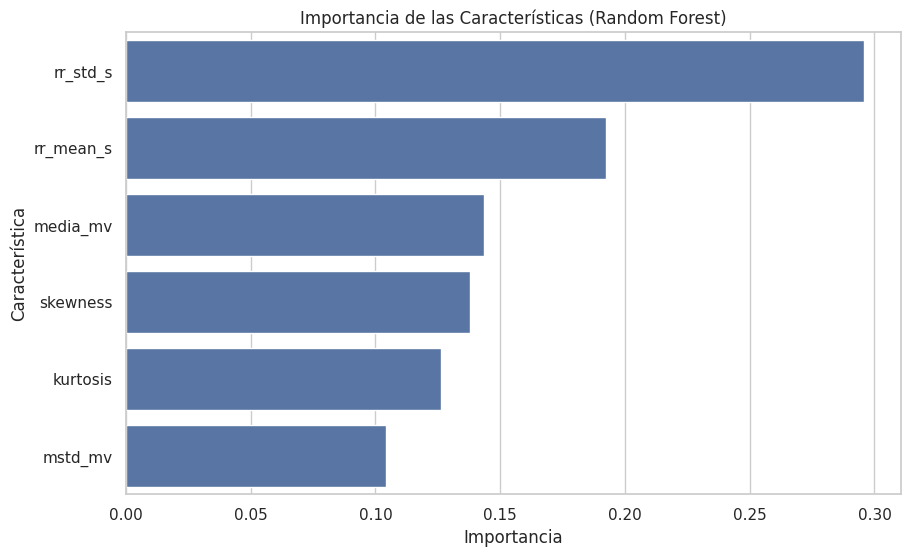

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Preparar los datos para el modelo
# Seleccionar características y etiquetas
features = ['media_mv', 'mstd_mv', 'skewness', 'kurtosis', 'rr_mean_s', 'rr_std_s']
X = df_features[features]
y = df_features['clase']

# Convertir etiquetas a formato numérico si es necesario (RandomForest puede manejar strings, pero es buena práctica)
# Aquí asumimos que 'N' y 'A' son las únicas clases de interés para el modelo, o que queremos clasificar todo.
# Si solo nos interesan N y A, filtramos el dataframe antes de entrenar.
df_filtered = df_selected[df_features['clase'].isin(['N', 'A'])]
X_filtered = df_filtered[features]
y_filtered = df_filtered['clase']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered) # stratify ayuda con desbalance de clases

# Entrenar el modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo con la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'N'], yticklabels=['A', 'N'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Importancia de las Características (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


Visualizar	errores	y	proponer	ideas	de	mejora

Creo que a modo personal, lo mejor qu es epodría hacer para aumentar el accuracy, es:
1.- Aumentar el tamaño del dataset
2.- Aumentar el tamaño de bosques para el random forest